In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [26]:
path = r"C:\Users\User\Documents\Python Scripts\bangla_local_language_data - Sheet1 (1).csv"

In [27]:
df=pd.read_csv(path)
print(df)

                                         Modern Bangla  \
0                                  আমি আপনাকে ঘৃণা করি   
1                                  আমি তোমায় ভালোবাসি   
2                               আমি তোমার প্রেমে পড়েছি   
3                                           আমি দুঃখিত   
4                                      আমি খুবই দুঃখিত   
...                                                ...   
3468                          বেশি গর্ব সর্বনাশের কারণ   
3469  অতি পরিচিত লোক গুণী হলেও উপযুক্ত মর্যাদা পায় না   
3470               অসৎ উপায়ে অর্জিত ধন অকাজে নষ্ট হয়   
3471              খারাপ কিছু থাকার চেয়ে না থাকাই ভালো   
3472                      অপচয় করবে না এবং অভাব হবে না   

                     Sylheti  Total Needed  Total Translated  
0     আমি আপনারে বালা পাই না        3473.0             647.0  
1        আমি তোমারে বালা পাই           NaN               NaN  
2     আমি তোমার বালা পাইলিছি           NaN               NaN  
3            আমার বুল অইগেছে           NaN         

In [28]:
df=df.drop(["Total Needed", "Total Translated"], axis=1)

In [29]:
df=df.dropna()

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Modern Bangla  647 non-null    object
 1   Sylheti        647 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [31]:
old_column_name = 'Modern Bangla'
new_column_name = 'Bangla'
df.rename(columns={'Modern Bangla': 'Bangla'}, inplace=True)

In [32]:
df['Bangla'] = df['Bangla'].astype(str)
df['Sylheti'] = df['Sylheti'].astype(str)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 647 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Bangla   647 non-null    object
 1   Sylheti  647 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [34]:
# Assuming your CSV has 'local_language' and 'original_bangla' columns
x = df['Sylheti'].astype(str)
y = df['Bangla'].astype(str)

In [35]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Tokenize the input (Sylheti) and target (Bangla) texts
local_tokenizer = Tokenizer()
local_tokenizer.fit_on_texts(X_train)
X_train_seq = local_tokenizer.texts_to_sequences(X_train)
X_val_seq = local_tokenizer.texts_to_sequences(X_val)

bangla_tokenizer = Tokenizer()
bangla_tokenizer.fit_on_texts(y_train)
y_train_seq = bangla_tokenizer.texts_to_sequences(y_train)
y_val_seq = bangla_tokenizer.texts_to_sequences(y_val)

In [36]:
# Pad sequences
max_len_bangla = 12
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len_bangla, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len_bangla, padding='post')

y_train_pad = pad_sequences(y_train_seq, maxlen=max_len_bangla, padding='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=max_len_bangla, padding='post')

# Define the sequence-to-sequence model architecture
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_len_bangla,))
encoder_embedding = Embedding(input_dim=len(local_tokenizer.word_index)+1, output_dim=latent_dim, input_length=max_len_bangla)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_bangla-1,))
decoder_embedding = Embedding(input_dim=len(bangla_tokenizer.word_index)+1, output_dim=latent_dim, input_length=max_len_bangla-1)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding(decoder_inputs), initial_state=encoder_states)
decoder_dense = Dense(len(bangla_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
optimizer = Adam()
loss = SparseCategoricalCrossentropy()
accuracy = SparseCategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# Print model summary
model.summary()

# Train the model
history = model.fit([X_train_pad, y_train_pad[:, :-1]], y_train_pad[:, 1:], 
                    validation_data=([X_val_pad, y_val_pad[:, :-1]], y_val_pad[:, 1:]), 
                    batch_size=32, epochs=15)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 11)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 256)   │    317,440 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 11, 256)   │    226,560 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 256),     │    525,312 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 11, 256), │    525,312 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ lstm_2[0][1],     │
│                     │ (None, 256)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 11, 885)   │    227,445 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,822,069 (6.95 MB)

 Trainable params: 1,822,069 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 5.6331 - sparse_categorical_accuracy: 0.4734 - val_loss: 2.1725 - val_sparse_categorical_accuracy: 0.6993
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.8431 - sparse_categorical_accuracy: 0.5836 - val_loss: 1.9945 - val_sparse_categorical_accuracy: 0.7070
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.6938 - sparse_categorical_accuracy: 0.5905 - val_loss: 1.9343 - val_sparse_categorical_accuracy: 0.6930
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.5976 - sparse_categorical_accuracy: 0.5905 - val_loss: 1.9086 - val_sparse_categorical_accuracy: 0.6930
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.5493 - sparse_categorical_accuracy: 0.5900 - val_loss: 1.8815 - val_sparse_categorical_accuracy: 0.6937
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.5091 - sparse_categorical_accuracy: 0.5902 - val_loss: 1.8630 - val_sparse_categorical_accuracy: 0.6979
Epoch 7/15

In [38]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate([X_val_pad, y_val_pad[:, :-1]], y_val_pad[:, 1:], verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 1.7313
Validation Accuracy: 0.7203


In [39]:
# Predict on validation data
y_val_pred = model.predict([X_val_pad, y_val_pad[:, :-1]])

# Convert predicted probabilities to label indices
y_val_pred_indices = np.argmax(y_val_pred, axis=-1)

# Compute evaluation metrics (example)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_val_pad[:, 1:].flatten(), y_val_pred_indices.flatten())
precision = precision_score(y_val_pad[:, 1:].flatten(), y_val_pred_indices.flatten(), average='weighted')
recall = recall_score(y_val_pad[:, 1:].flatten(), y_val_pred_indices.flatten(), average='weighted')
f1 = f1_score(y_val_pad[:, 1:].flatten(), y_val_pred_indices.flatten(), average='weighted')
cm = confusion_matrix(y_val_pad[:, 1:].flatten(), y_val_pred_indices.flatten())

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("Validation F1 Score:", f1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Validation Accuracy: 0.7202797202797203
Validation Precision: 0.6799929086606545
Validation Recall: 0.7202797202797203
Validation F1 Score: 0.6924535348457739


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


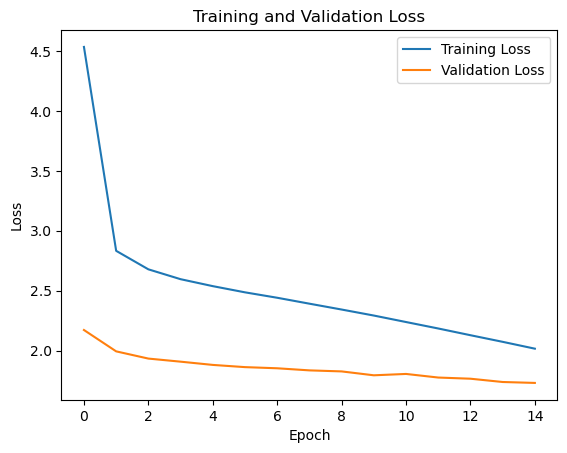

In [40]:
import matplotlib.pyplot as plt

# Train the model
#history = model.fit([X_train_padded, X_train_padded], y_train_padded, epochs=20, batch_size=32, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

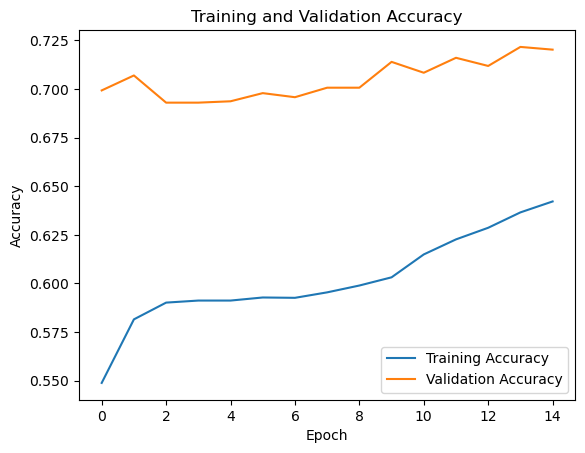

In [42]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()